In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем данные
data=pd.read_csv('asset-v1_SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
data.tail()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M
606,606,2022,MI,FT,AI Scientist,200000,USD,200000,IN,100,US,L


In [4]:
# смотрим информация наши датасети
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [5]:
df=data.copy()

In [6]:
# проверим о наличие пропуске
df.isnull().sum()


Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

наши данны нет пропуск

In [7]:
# смотрим ести ли дубликатов
duplicates = df[df.duplicated()]
print(f'число найденных дубликатов: {duplicates.shape[0]}')
# Удаляем дубликаты:
df = df.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(df.shape))

число найденных дубликатов: 0
Размер таблицы после удаления дубликатов: (607, 12)


In [8]:
# смотрим о неинформативности признаки
low_information_cols = []
for col in df.columns:
    top_freq = df[col].value_counts(normalize=True).max() 
    nunique_ratio = df[col].nunique() / df[col].count()   
    
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq * 100, 2)}% одинаковый значение (неинформативный)')
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio * 100, 2)}% уникальных значение (неинформативный)')

low_information_drop = df.drop(columns=low_information_cols)
print(f'Результирующее число признаков: {low_information_drop.shape[1]}')


Unnamed: 0: 100.0% уникальных значение (неинформативный)
employment_type: 96.87% одинаковый значение (неинформативный)
Результирующее число признаков: 10


In [9]:
# создаем функция который будет выявить числовые признаков
def get_int_var(df):
    int_number=[]
    for col in df.columns[:12]:
        if df[col].dtype in ['int64', 'float64']:
            print(f'{col}:{df[col].dtype}')
            int_number.append(col)
    return int_number 
int_numeric=get_int_var(df)       

Unnamed: 0:int64
work_year:int64
salary:int64
salary_in_usd:int64
remote_ratio:int64


In [10]:
# создаем функция который будет выявить категориальные признаков
def get_cat_var(df):
    cat_number=[]
    for col in df.columns[:12]:
        if df[col].dtype in ['object', 'category']:
            print(f'{col}:{df[col].dtype}')
            cat_number.append(col)
    return cat_number 
cat_numeric=get_cat_var(df)   

experience_level:object
employment_type:object
job_title:object
salary_currency:object
employee_residence:object
company_location:object
company_size:object


In [11]:
# смотрим на основные статистические характеристики
df.describe()

,Unnamed: 0,work_year,salary,salary_in_usd,remote_ratio
count,607.000000,607.000000,6.070000e+02,607.000000,607.00000
mean,303.000000,2021.405272,3.240001e+05,112297.869852,70.92257
std,175.370085,0.692133,1.544357e+06,70957.259411,40.70913
min,0.000000,2020.000000,4.000000e+03,2859.000000,0.00000
25%,151.500000,2021.000000,7.000000e+04,62726.000000,50.00000
50%,303.000000,2022.000000,1.150000e+05,101570.000000,100.00000
75%,454.500000,2022.000000,1.650000e+05,150000.000000,100.00000
max,606.000000,2022.000000,3.040000e+07,600000.000000,100.00000


In [12]:
df.describe(include='object')

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,607,607,607,607,607,607,607
unique,4,4,50,17,57,50,3
top,SE,FT,Data Scientist,USD,US,US,M
freq,280,588,143,398,332,355,326


#### факторы влияют на зарплату Data Scientist

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


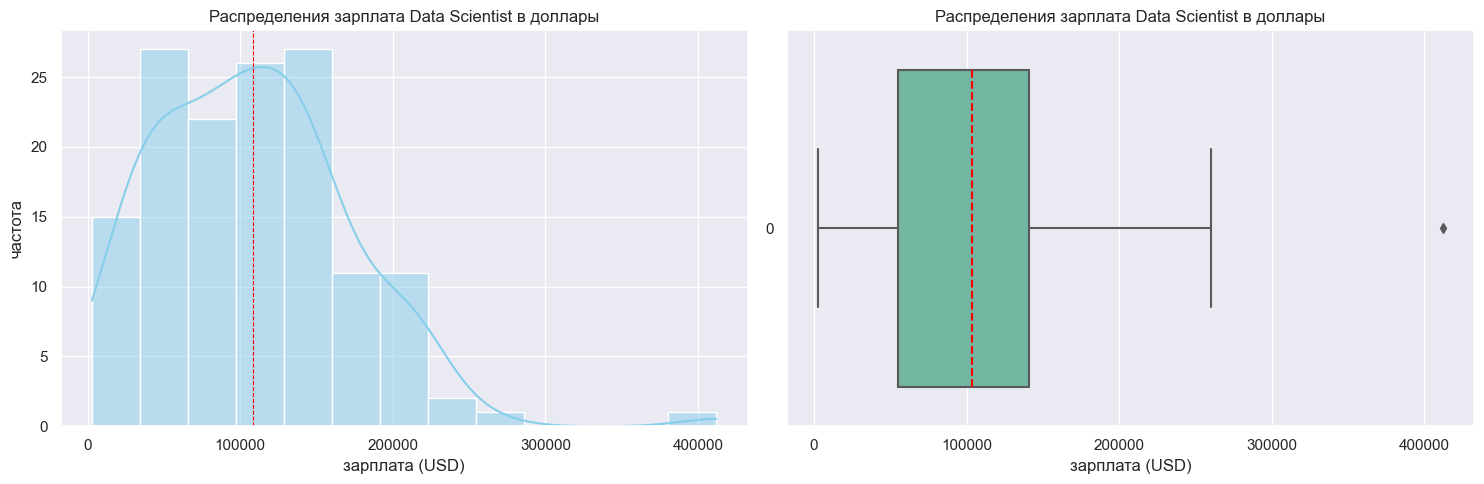

In [13]:
# смотрим на зарплату Data Scientist в доллары
# сначала фильтруем данных для Data Scientist
ds_data=df[df['job_title']=='Data Scientist']
# создадим графиков
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ds_data['salary_in_usd'], kde=True, ax=axes[0], color='skyblue')
axes[0].set(
    xlabel='зарплата (USD)',
    ylabel='частота',
    title='Распределения зарплата Data Scientist в доллары'
)
axes[0].axvline(ds_data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8, label='средняя зарплата')
# boxplot
sns.boxplot(ds_data['salary_in_usd'], ax=axes[1], orient='h', medianprops={'color':'red', 'linestyle':'--'})
axes[1].set(
    xlabel='зарплата (USD)', 
    title='Распределения зарплата Data Scientist в доллары'
)
plt.tight_layout()
plt.show()

Распределения признак отлично от нормального. Т.е большинство наблюдения сосредоточен от 0 до 100000. Это значить что, до 100000 платится большеснтво специалисты Data Scientist а больше 100000 выплатится меньше специалисты и частота постепено подает и создает выбросы 

In [14]:
data_agg = ds_data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплата DS (USD)']
data_agg

,Размер зарплата DS (USD)
count,143.00
mean,108187.83
std,64112.84
min,2859.00
25%,54724.00
50%,103691.00
75%,140850.00
max,412000.00


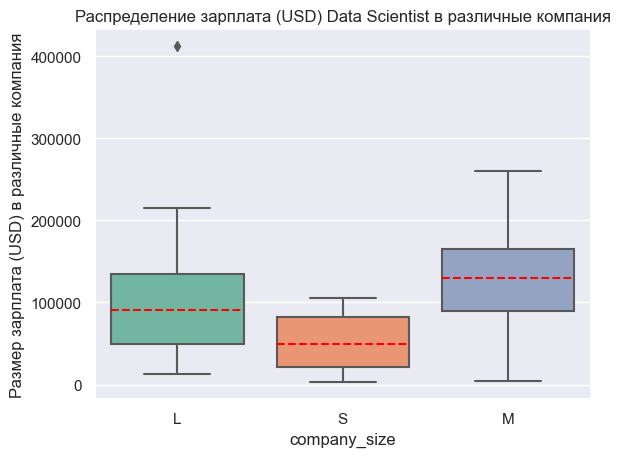

In [20]:
# смотрим на зарплату Data Scientist в зависимости от размеры компания
ax=sns.boxplot(ds_data, x='company_size', y='salary_in_usd', medianprops={"color": "red", "linestyle": '--'})
ax.set(ylabel='Размер зарплата (USD) в различные компания')
plt.title('Распределение зарплата (USD) Data Sсientist в различные компания')
plt.show()

In [16]:
data_agg = ds_data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Распределения в зависимости от company_size')
data_agg

Распределения в зависимости от company_size


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,45.0,103313.36,71815.18,13400.0,50000.0,90734.0,135000.0,412000.0
M,77.0,126380.75,56389.53,4000.0,90000.0,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


Распределения визуальное отличается в зависимости от company_size, видно что средня компания платить больше чем остальное, но средная значения для всех тоже отличаются, наблюдается что средня значения для среднее компания тоже больше, это может случится из за того что у них мало работников в отличие от крупная компания.

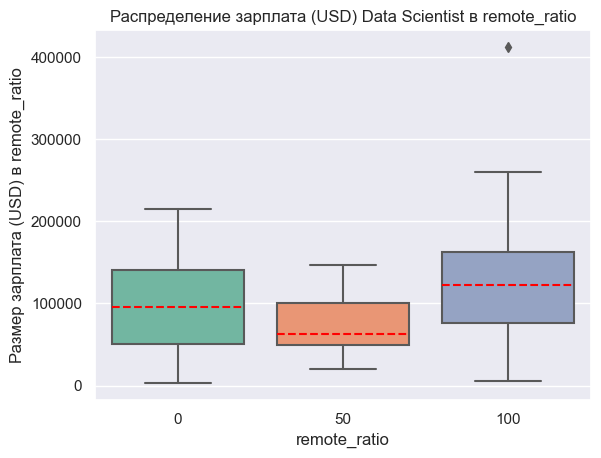

In [21]:
# смотрим на зарплату Data Scientist в зависимости от график работы
ax=sns.boxplot(ds_data, x='remote_ratio', y='salary_in_usd', medianprops={"color": "red", "linestyle": '--'})
ax.set(ylabel='Размер зарплата (USD) в remote_ratio')
plt.title('Распределение зарплата (USD) Data Sсientist в remote_ratio')
plt.show()

In [22]:
data_agg = ds_data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Распределения в зависимости от remote_ratio')
data_agg

Распределения в зависимости от remote_ratio


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,39.0,99520.74,58259.42,2859.0,50294.5,95550.0,140400.0,215300.0
50,25.0,74504.08,35602.82,20171.0,49646.0,62726.0,100000.0,147000.0
100,79.0,123125.94,69370.99,5679.0,76366.0,123000.0,162500.0,412000.0


здесь можно визуальное смотрит что, данных отличают между сабой. можно делать выводы что тех кто полностю работает удаленная получает больше, и тех кто не работает удаленна больше получает чем тех кто частичная работает

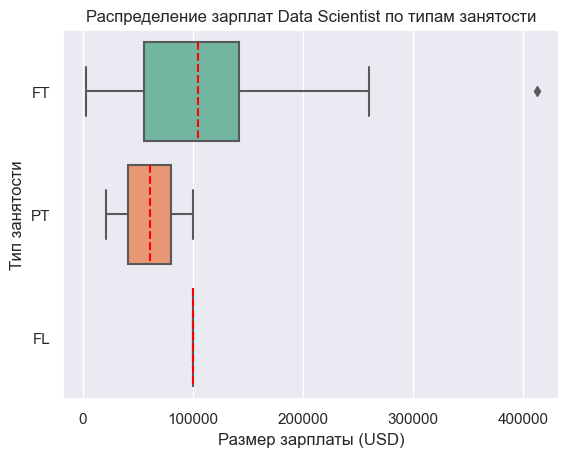

In [23]:
# зарплату Data Scientist в зависимост от вид занятости
ax = sns.boxplot(
    data=ds_data, 
    y='employment_type', 
    x='salary_in_usd', 
    palette='Set2',
    medianprops={"color": "red", "linestyle": '--'}
)
ax.set(
    xlabel='Размер зарплаты (USD)', 
    ylabel='Тип занятости'
)
plt.title('Распределение зарплат Data Scientist по типам занятости')
plt.show()

In [24]:
data_agg = ds_data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Распределения в зависимости от employment_type')
data_agg

Распределения в зависимости от employment_type


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,140.0,108922.79,64372.43,2859.0,55490.00,104796.0,141975.00,412000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


наши вывод следуюшии : больше получает тех кто работает полный день, но смотрим что минимальное и макимальное значения у freelancer совпадает со среднее значения для польны день

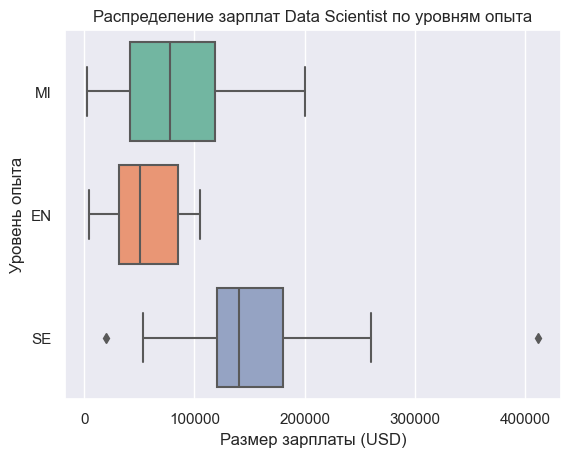

In [25]:
# зарплаты Data Scientist в зависимости от уровне опыта работы
ax = sns.boxplot(
    data=ds_data, 
    y='experience_level',  # Ось Y — уровень опыта
    x='salary_in_usd',  # Ось X — зарплата
    palette='Set2'
)
ax.set(
    xlabel='Размер зарплаты (USD)', 
    ylabel='Уровень опыта'  # Исправлено название оси
)
plt.title('Распределение зарплат Data Scientist по уровням опыта')
plt.show()

In [26]:
data_agg = ds_data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Распределения в зависимости от employment_type')
data_agg

Распределения в зависимости от employment_type


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,60.0,82039.13,46869.58,2859.0,41768.0,77479.0,118264.75,200000.0
SE,61.0,152971.02,58985.40,20171.0,120000.0,140400.0,180000.00,412000.0


график отличается визуально, видно что у senior Data Scientist больше остальное а второй получает middle их средне значения тоже отличается тоже самый минимальное значения

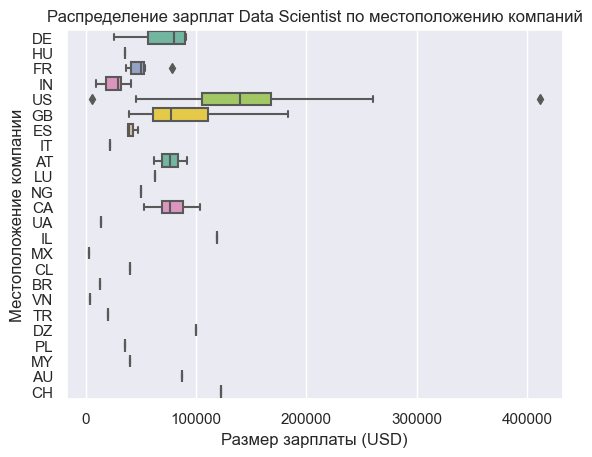

In [27]:
# зарплаты Data Scientist в зависимости от место компания
ax = sns.boxplot(
    data=ds_data, 
    y='company_location',  # Ось Y — местоположение компании
    x='salary_in_usd',  # Ось X — зарплата
    palette='Set2'
)
ax.set(
    xlabel='Размер зарплаты (USD)', 
    ylabel='Местоположение компании'  # Исправлено название оси
)
plt.title('Распределение зарплат Data Scientist по местоположению компаний')
plt.show()

видно что компания который находятся в сша платять больше чем остальное, а следующая страна это Великобритания

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


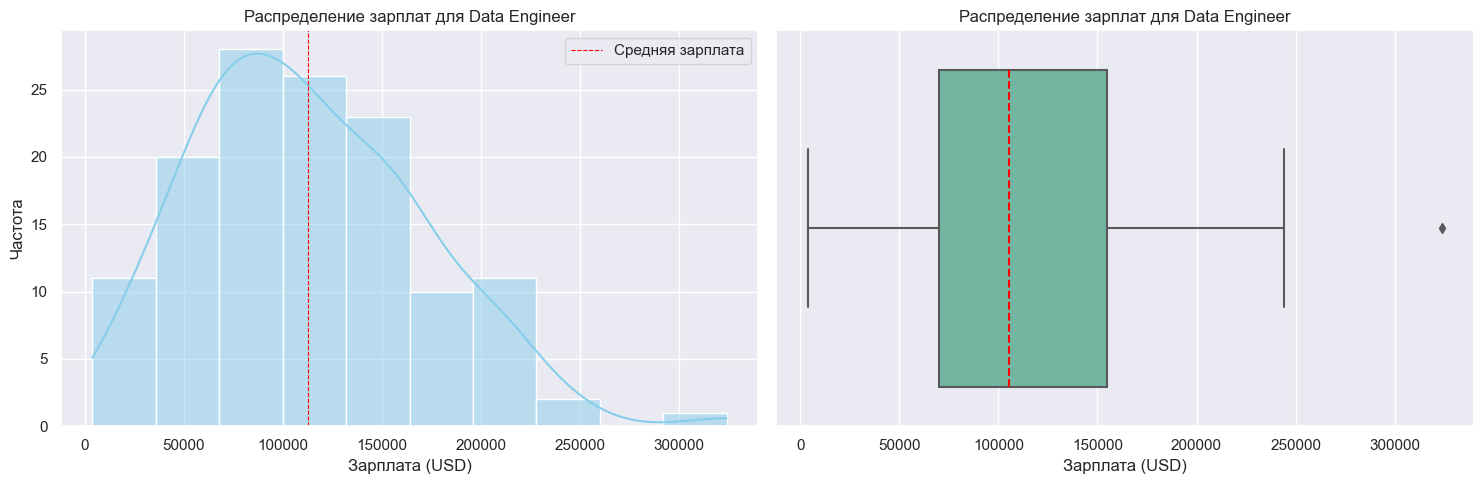

In [28]:
# зарплата Data Engineer
# Фильтрация данных для Data Engineer
df_engineer = df[df['job_title'] == 'Data Engineer']

# Проверяем, есть ли данные в отфильтрованном DataFrame
if not df_engineer.empty:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Гистограмма с KDE
    sns.histplot(df_engineer['salary_in_usd'], kde=True, ax=axes[0], color='skyblue')
    axes[0].set(
        xlabel='Зарплата (USD)',
        ylabel='Частота',
        title='Распределение зарплат для Data Engineer'
    )
    axes[0].axvline(df_engineer['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8, label='Средняя зарплата')
    axes[0].legend()

    # Boxplot
    sns.boxplot(
        x=df_engineer['salary_in_usd'], 
        ax=axes[1], 
        medianprops={"color": "red", "linestyle": '--'}
    )
    axes[1].set(
        xlabel='Зарплата (USD)',
        title='Распределение зарплат для Data Engineer'
    )

    # Улучшение отображения графиков
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для 'Data Engineer'")

Распределения признак отлично от нормального. Т.е большинство наблюдения сосредоточен от 0 до 100000. Это значить что, до 100000 платится большеснтво специалисты Data Scientist а больше 100000 выплатится меньше специалисты и частота постепено подает и есть выбросы 

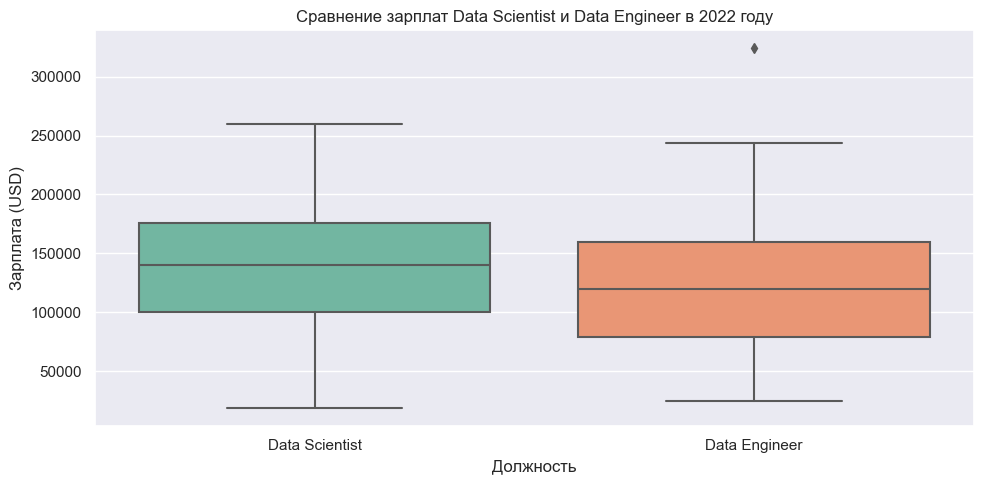

In [29]:
# Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
df_2022 = df[df['work_year'] == 2022]

# Фильтрация данных для Data Scientist и Data Engineer
ds_data_2022 = df_2022[df_2022['job_title'] == 'Data Scientist']
de_data_2022 = df_2022[df_2022['job_title'] == 'Data Engineer']

# Создание списка для сравнения
comparison_data = pd.concat([
    ds_data_2022[['job_title', 'salary_in_usd']],
    de_data_2022[['job_title', 'salary_in_usd']]
])

# Построение boxplot для сравнения зарплат
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='job_title', y='salary_in_usd', data=comparison_data, palette='Set2')

# Установка подписей и заголовков
plt.title('Сравнение зарплат Data Scientist и Data Engineer в 2022 году')
plt.xlabel('Должность')
plt.ylabel('Зарплата (USD)')

# Отображение графика
plt.tight_layout()
plt.show()


можно смотрит в этом график что среднее значения и максимальная граница у Data Scientist больше чем у Data Engineer но видно что у график для Data Engineer усть выбросы которое дает знать что они больше получили, но этот данный нельзя доверять пока

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


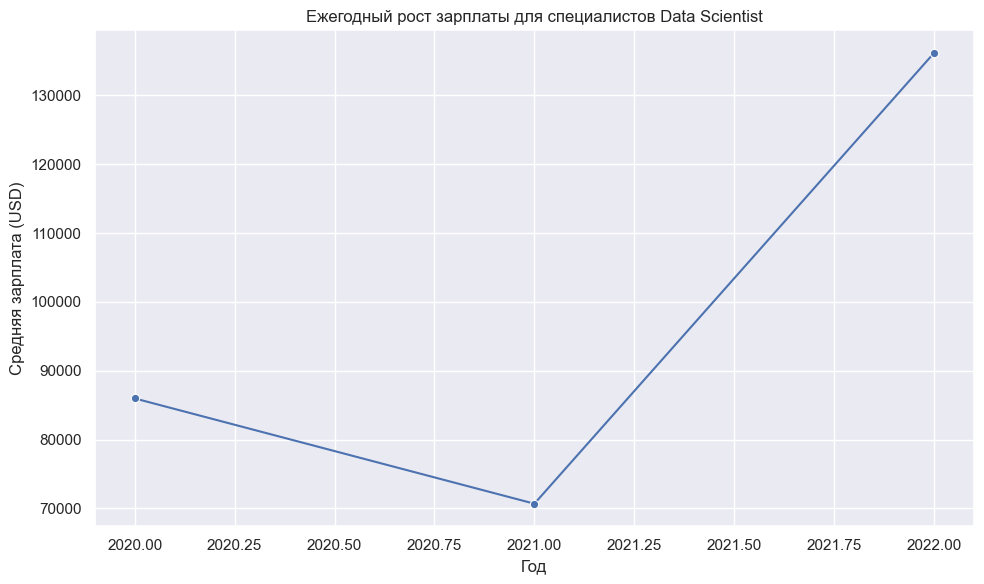

In [30]:
# Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
# Группировка по году и расчёт средней зарплаты
salary_by_year = ds_data.groupby('work_year')['salary_in_usd'].mean()

# Построение графика
plt.figure(figsize=(10, 6))
sns.lineplot(x=salary_by_year.index, y=salary_by_year.values, marker='o', color='b')

# Настройка графика
plt.title('Ежегодный рост зарплаты для специалистов Data Scientist')
plt.xlabel('Год')
plt.ylabel('Средняя зарплата (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

в график видно что было изменение в зарплату, так как с 2020 до начала 2021 наблюдается распад но с 2021 года наблюдается рости зарплату специалисты

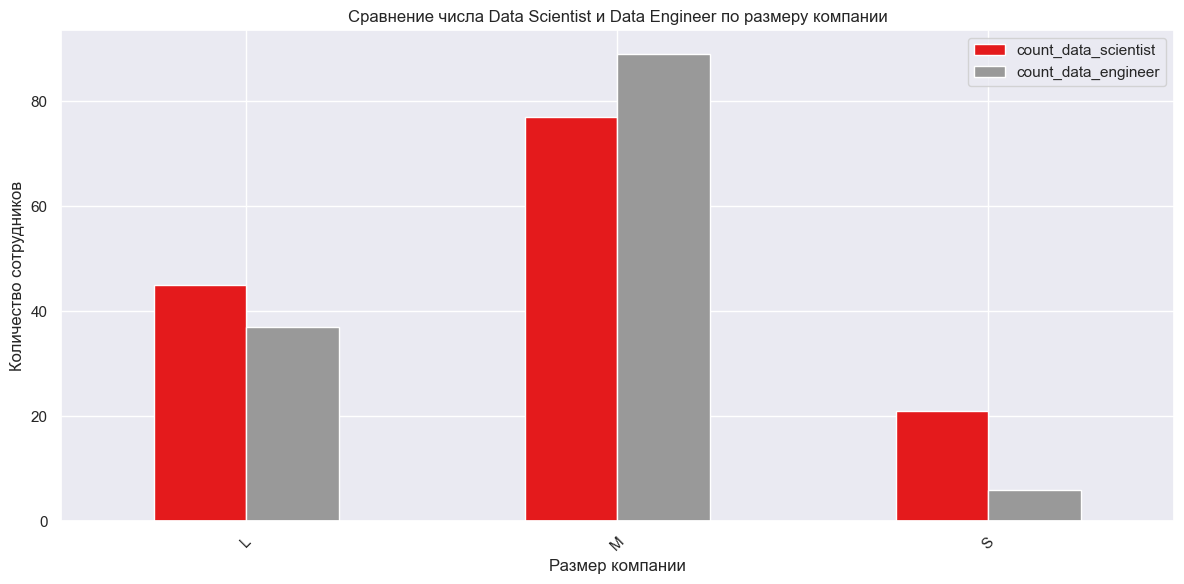

In [31]:
# Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

# Фильтрация данных для Data Scientist и Data Engineer
ds_data = df[df['job_title'] == 'Data Scientist']
de_data = df[df['job_title'] == 'Data Engineer']

# Проверим, существует ли столбец 'company_size'
if 'company_size' in df.columns:
    # Создаём датафрейм с количеством Data Scientist и Data Engineer по размеру компании
    company_size_ds = ds_data.groupby('company_size')['job_title'].count().reset_index(name='count_data_scientist')
    company_size_de = de_data.groupby('company_size')['job_title'].count().reset_index(name='count_data_engineer')
    
    # Объединяем оба датафрейма по размеру компании
    company_sizes = pd.merge(company_size_ds, company_size_de, on='company_size', how='outer').fillna(0)

    # Построение графика для сравнения
    company_sizes.set_index('company_size', inplace=True)
    company_sizes.plot(kind='bar', figsize=(12, 6), colormap='Set1')

    # Настройка графика
    plt.title('Сравнение числа Data Scientist и Data Engineer по размеру компании')
    plt.xlabel('Размер компании')
    plt.ylabel('Количество сотрудников')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("Нет столбца 'company_size' в данных.")


да! есть связи между них:
в маленькая компания свзи между них есть маленькии, а в средняя по больше а уже в крупная компания очень маленькии связи

In [44]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Статистический анализ данных

In [81]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p_value = {:.3f}'.format(p))
    if p <= alpha:
        print('p_value меньше, чем заданный значения уровень значимости {:.2f}.Распеделения отлично от норманого'.format(alpha))
    else:
        print('p_value больше, больше чем заданный уровень значимости {:.2f}. Распределения является нормальный'.format(alpha))
        
# функция для принятия решения о гипотезы
def decision_hypothesis(p):
    print('p_value={:.3f}'.format(p)) 
    if p<=alpha:
        print('p_value меньше, чем заданный уровень значимости {:.2f}. отвергаем нулевую гипотезу'.format(alpha))
    else:
        print('p_value больше, чем заданный уровень значимости {:.2f}. принимаем нулевую гипотезу'.format(alpha)) 
        
# функция для принятие решения на равенство дисперсии  
def decision_dispersion(p):
    print('p_value = {:.3f}'.format(p))
    if p<= alpha:
        print('Дисперсии не одинаковый, в stats.ttest_ind нужно использовать параметр equal_var=False!')  
    else:
        print('Дисперсии одинаковый, в stats.ttest_ind нужно использовать параметр equal_var=True!')  
        
# # функция для принятие решения на равенство дисперсии  ANOVA     
def dispersion_anova(p):
    print('p_value = {:.3f}'.format(p))
    if p<= alpha:
        print('Дисперсии не одинаковый, нужно использовать непараметрические тест')  
    else:
        print('Дисперсии одинаковый, мы можем использовать Тест ANOVA!')                       

### наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативный гипотезы**

*нулевая гипотеза* ($H_0$): Размер ежегодный рост зарплат Data Scientist ($μ$) статистический больше либо равен средня значения выборк ($μ_0$).

$$ H_0 : μ >= μ_0$$

*Альтернативная гипотеза* ($H_1$): Размер ежегодный рост зарплат Data Scientist ($μ$) статистически меньше, чем средня значения выборк ($μ_0$).

$$ H_1 : μ < μ_0$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [58]:
result=stats.shapiro(salary_by_year)
decision_normality(result[1])

p_value = 0.43
p_value больше, больше чем заданный уровень значимости 0.05. Распределения является нормальный


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер ежегодный рост зарплат »? — Количественный.
* Сколько сравниваемых групп? — один.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать Т-тест для сравнения распределений на основе рангов.

**Проведём тест**

In [59]:
# Проводим тест
_, p=stats.ttest_1samp(salary_by_year, alternative='less', popmean=108187.83)
decision_hypothesis(p)

p_value=0.32
p_value больше, чем заданный уровень значимости 0.05. принимаем нулевую гипотезу


**Вывод**

У нас есть оснований утверждать, что существует ежегодный рост зарплат Data Scientist.

### Как соотносится зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативный гипотезы**

*нулевая гипотеза* ($H_0$): Размер зарплат Data Scientist ($μ_1$) статистический меньше либо равен Размер зарплат Data Engineer ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Размер зарплат Data Scientist ($μ_1$) статистически больше, чем Размер зарплат Data Engineer ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [77]:
# Фильтрация данных за 2022 год
df_2022 = df[df['work_year'] == 2022]

# Фильтрация по профессиям
ds_data_2022 = df_2022[df_2022['job_title'] == 'Data Scientist']['salary_in_usd']
de_data_2022 = df_2022[df_2022['job_title'] == 'Data Engineer']['salary_in_usd']

# Проведение теста Шапиро-Уилка для проверки нормальности распределения
print("Для Data Scientist:")
result = stats.shapiro(ds_data_2022)
decision_normality(result[1])

print("Для Data Engineer:")
result = stats.shapiro(de_data_2022)
decision_normality(result[1])

Для Data Scientist:
p_value = 0.327
p_value больше, больше чем заданный уровень значимости 0.05. Распределения является нормальный
Для Data Engineer:
p_value = 0.010
p_value меньше, чем заданный значения уровень значимости 0.05.Распеделения отлично от норманого


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака ? — Количественный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать ttest_ind().

**Проведём тест**

In [78]:
# тест на равенство дисперсии
result=stats.levene(ds_data_2022, de_data_2022)
decision_dispersion(result[1])

p_value = 0.603
Дисперсии одинаковый, в stats.ttest_ind нужно использовать параметр equal_var=True!


In [79]:
# проводим тест
_, p = stats.ttest_ind(ds_data_2022, de_data_2022, alternative='greater', equal_var=True)
decision_hypothesis(p)

p_value=0.128
p_value больше, чем заданный уровень значимости 0.05. принимаем нулевую гипотезу


**Выводы**

У нас нет есть оснований утверждать, что зарплат Data Scientisт больше чем Data Engineer в 2022 году

### Как соотносится зарплаты специалистов Data scientist и Data Engineer в компании различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплаты специалистов в компании различных размеров не отличается: L ($μ_1$), S ($μ_2$), M ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер зарплаты специалистов в компании различных размеров отличается: L ($μ_1$), S ($μ_2$), M ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [82]:
salary_l = ds_data.loc[ds_data['company_size']=='L', 'salary_in_usd' ]
salary_s = ds_data.loc[ds_data['company_size']=='S', 'salary_in_usd' ]
salary_m = ds_data.loc[ds_data['company_size']=='M', 'salary_in_usd' ]
# проводим тест
result=stats.shapiro(salary_l)
decision_normality(result[1])

result=stats.shapiro(salary_s)
decision_normality(result[1])

result=stats.shapiro(salary_m)
decision_normality(result[1])

p_value = 0.000
p_value меньше, чем заданный значения уровень значимости 0.05.Распеделения отлично от норманого
p_value = 0.189
p_value больше, больше чем заданный уровень значимости 0.05. Распределения является нормальный
p_value = 0.639
p_value больше, больше чем заданный уровень значимости 0.05. Распределения является нормальный


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «размеры различные компании»? — Количественный.
* Сколько сравниваемых групп? — три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — да. 

Для проверки нашей гипотезы можно использовать критерий f_oneway().

**Проведём тест**

In [83]:
# проводим тест на равенство дисперсии
result=stats.levene(salary_l, salary_s, salary_m)
dispersion_anova(result[1])

p_value = 0.056
Дисперсии одинаковый, мы можем использовать Тест ANOVA!


In [84]:

# Проведение ANOVA
_, p = stats.f_oneway(salary_l, salary_s, salary_m)

# Принятие решения
decision_hypothesis(p)

p_value=0.000
p_value меньше, чем заданный уровень значимости 0.05. отвергаем нулевую гипотезу


**Вывод**

У нас есть оснований утверждать, что есть разница в размер зарплаты специалистов в компании различных размеров.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между тем, работать в одном или другая компания, и занимаемый должности нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между тем, работать в одном или другая компания, и занимаемый должности  есть взаимосвязь (признаки зависимы).

In [67]:
cancat_df=pd.concat([
    ds_data, df_engineer
])
table = pd.crosstab(cancat_df['job_title'], cancat_df['company_size'])
table

company_size,L,M,S
job_title,,,
Data Engineer,37,89,6
Data Scientist,45,77,21


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признаки? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [68]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(table)
decision_hypothesis(p)

p_value=0.008
p_value меньше, чем заданный уровень значимости 0.05. отвергаем нулевую гипотезу


**Вывод**

Существует статистически значимая взаимосвязь работать в одном или другая компания и занимамый должности.

## Итоговые результаты исследования

*   У нас есть оснований утверждать, что существует ежегодный рост зарплат Data Scientist.
*   У нас нет есть оснований утверждать, что зарплат Data Scientisт больше чем Data Engineer в 2022 году.
*   У нас есть оснований утверждать, что есть разница в размер зарплаты специалистов в компании различных размеров.
*   Существует статистически значимая взаимосвязь работать в одном или другая компания и занимамый должности.